## This notebook illustrates every step of the process of training models for ic labeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

First of all, we need the dataset. We can download and it using the following commands.

In [ ]:
!curl -O http://168.119.186.83/media/downloads/dataset_Kids_v0.1.zip
!unzip dataset_Kids_v0.1.zip

Now, we load the dataset. For this we use the special function, which reads the csv-files from the directory and puts the data in a convenient format.

In [2]:
from data import load_dataset

dir = 'dataset_Kids'

data, raw_annotations = load_dataset(dir)

Now, we calculate features for each ic in the dataset.

In [3]:
from features import build_feature_df

features = build_feature_df(data, default=True, custom_features={})
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,AMALB
IC000262,1.072924,7.849818,1.218625,0.312472,0.034570,0.048681,0.019231,0.008782,0.532586,-0.436746,1.011637
IC000263,-0.258669,2.826228,-0.098488,-0.017333,0.198680,0.194712,0.000708,0.000991,0.117395,0.040816,2.849186
IC000264,-0.281039,2.405500,0.048190,-0.005600,0.195810,0.135989,0.000826,0.001222,0.156479,-0.006563,3.377169
IC000265,-0.109386,2.304496,-0.153483,-0.047035,0.102357,0.137081,0.001293,0.000845,-0.015456,0.105652,3.772572
IC000266,-0.184636,2.180311,-0.098674,-0.010143,0.185123,0.238028,0.000109,0.000302,-0.036227,0.126880,3.964019
...,...,...,...,...,...,...,...,...,...,...,...
IC000877,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,0.000665,0.001510,0.065716,0.016142,3.993653
IC000878,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,0.001756,0.001765,-0.005558,0.079040,4.264880
IC000879,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,0.000769,0.000845,0.049253,-0.022909,4.072748
IC000880,-0.177250,3.021220,-0.042368,-0.000086,0.097905,0.117893,0.000812,0.001312,-0.050189,0.038057,4.659919


Targets are calculated as the average of the answers of multiple experts for each ic.

In [4]:
def get_target_distribution(annotations):
    return annotations.groupby('ic_id').mean().apply(lambda x: x.value_counts())

get_target_distribution(raw_annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_line_noise,flag_ch_noise
0.000000,94.0,546.0,523.0,243.0,536.0,564.0,306.0,369.0,608.0,380.0
0.142857,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
0.200000,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN
0.250000,NaN,4.0,1.0,3.0,5.0,3.0,NaN,5.0,NaN,NaN
0.333333,9.0,10.0,4.0,17.0,3.0,2.0,17.0,12.0,2.0,4.0
0.400000,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
0.500000,115.0,52.0,77.0,311.0,63.0,39.0,170.0,222.0,10.0,193.0
0.600000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0.666667,18.0,NaN,NaN,2.0,1.0,NaN,11.0,1.0,NaN,4.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now we do not want to distinguish between eye movement types, so we unite them under `'flag_eyes'`. We also presume the positive label for `'flag_alpha'` or `'flag_mu'` implies the positive label for `'flag_brain'`. Finally, since we do not have sufficient data for distinguishing line noise, we will not consider this flag.

In [5]:
def propogate_labels(annotations):
    return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_line_noise'])

annotations = propogate_labels(raw_annotations)
get_target_distribution(annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_ch_noise
0.000000,93.0,546.0,523.0,243.0,536.0,564.0,306.0,369.0,380.0
0.142857,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
0.200000,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN
0.250000,NaN,4.0,1.0,3.0,5.0,3.0,NaN,5.0,NaN
0.333333,9.0,10.0,4.0,17.0,3.0,2.0,17.0,12.0,4.0
0.400000,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
0.500000,103.0,52.0,77.0,311.0,63.0,39.0,170.0,222.0,193.0
0.600000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0.666667,12.0,NaN,NaN,2.0,1.0,NaN,11.0,1.0,4.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to get binary labels we apply threshold to these averages. By default, the each label has weight $\frac{1}{n}$, where $n$ is the number of labels given to the ic by this expert. We set the threshold to $0.33$ For flags `alpha` and `mu` we choose a simpler approach: each label has weight $1$. The threshold in this case is equal to $0.5$.

In [6]:
from data import build_target_df
targets = build_target_df(annotations, weights='uniform', strategy='mean', threshold=0.33)

targets[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

print(targets.sum())
targets = targets.loc[:, (targets.mean(axis=0) > 0.05) & (targets.all(axis=0) < 0.95)]
targets.head()

flag_brain       446
flag_alpha        60
flag_mu           92
flag_eyes         53
flag_eyes_h       13
flag_eyes_v       13
flag_muscles     134
flag_heart       231
flag_ch_noise     48
dtype: int64


,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False


For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [7]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

models = {'LR': LogisticRegression(solver='liblinear', penalty='l2', C=1.0),
          'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
          'SVM': SVC(kernel='linear', probability=True)}
n_repeats = 50

In [8]:
from sklearn.model_selection import train_test_split

def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_pred), np.array(y_proba)


In [9]:
from vis import plot_aggregated_pr_curve, plot_aggregated_roc_curve

def plot_curves_grid(features, targets, models):

    fig_roc, axes_roc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
    fig_pr, axes_pr = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

    for (model_name, model), row_roc, row_pr in zip(models.items(), axes_roc, axes_pr):
        for flag, ax_roc, ax_pr in zip(targets, row_roc, row_pr):
            y_true, _, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
            plot_aggregated_roc_curve(y_true, y_proba, ax_roc)
            plot_aggregated_pr_curve(y_true, y_proba, ax_pr)

        row_roc[0].set_ylabel(model_name, fontsize=28, labelpad=16)
        row_pr[0].set_ylabel(model_name, fontsize=28, labelpad=16)

        row_roc[-1].set_ylabel('True positive rate', fontsize=18)
        row_pr[-1].set_ylabel('Precision', fontsize=18)
        row_roc[-1].yaxis.set_label_position('right')
        row_pr[-1].yaxis.set_label_position('right')

    for target_name, ax_roc, ax_pr in zip(targets, axes_roc[0], axes_pr[0]):
        ax_roc.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)
        ax_pr.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)

    for ax_roc, ax_pr in zip(axes_roc[-1], axes_pr[-1]):
        ax_roc.set_xlabel('False positive rate', fontsize=18)
        ax_pr.set_xlabel('Recall', fontsize=18)

    fig_roc.subplots_adjust(wspace=0.1, hspace=0.1)
    fig_pr.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_roc, row_pr in zip(axes_roc[:-1], axes_pr[:-1]):
        for ax_roc, ax_pr in zip(row_roc, row_pr):
            plt.setp(ax_roc.get_xticklabels(), visible=False)
            plt.setp(ax_pr.get_xticklabels(), visible=False)

    for row_roc, row_pr in zip(axes_roc, axes_pr):
        for ax_roc, ax_pr in zip(row_roc[:-1], row_pr[:-1]):
            plt.setp(ax_roc.get_yticklabels(), visible=False)
            plt.setp(ax_pr.get_yticklabels(), visible=False)

    return fig_roc, fig_pr

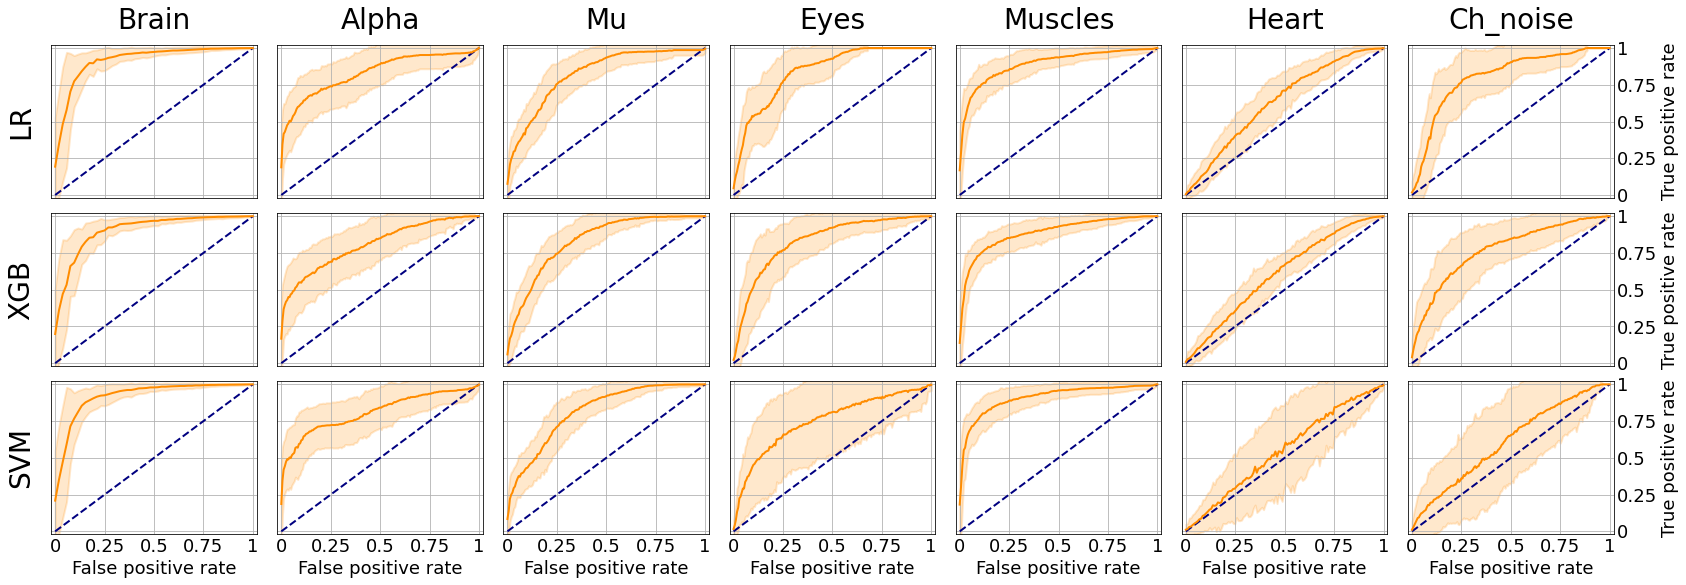

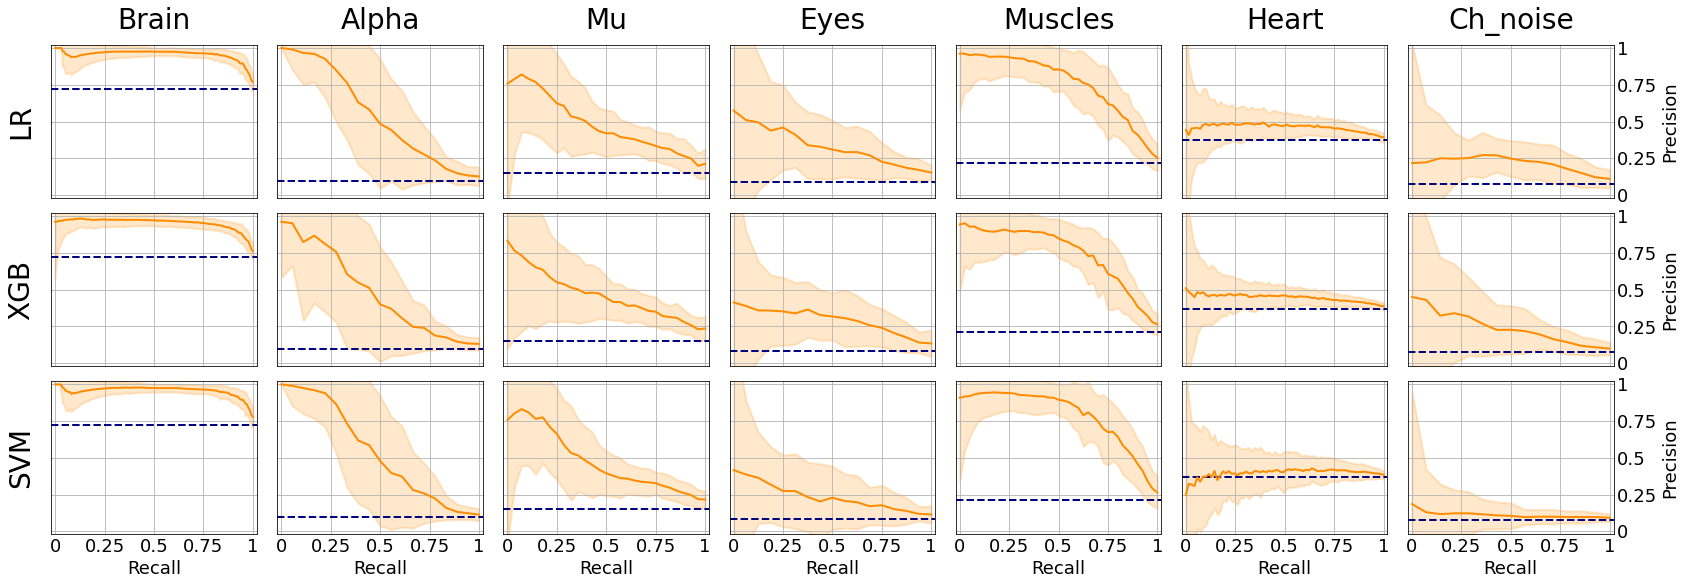

In [10]:
fig_roc, fig_pr = plot_curves_grid(features, targets, models)

In [11]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve

def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for true, proba in zip(y_true, y_proba):
        fpr, tpr, _ = roc_curve(true, proba, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(true, proba)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

In [12]:
from itertools import product
from sklearn.metrics import f1_score

roc_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
pr_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
f1_scores = pd.DataFrame(index=models, columns=targets.columns, dtype=float)

for (model_name, model), flag in product(models.items(), targets):
        y_true, y_pred, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
        roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
        f1_score_values = [f1_score(true, pred) for true, pred in zip(y_true, y_pred)]
        roc_aucs.loc[model_name, flag] = np.mean(roc_auc_values)
        pr_aucs.loc[model_name, flag] = np.mean(pr_auc_values)
        f1_scores.loc[model_name, flag] = np.mean(f1_score_values)


In [13]:
roc_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.925075,0.831667,0.825502,0.843176,0.893562,0.637025,0.807450
XGB,0.913117,0.808872,0.834073,0.832290,0.889705,0.611318,0.772757
SVM,0.927922,0.811425,0.817021,0.749463,0.910892,0.551594,0.608223


In [14]:
pr_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.958100,0.592671,0.497034,0.362311,0.776387,0.463452,0.234137
XGB,0.955585,0.536909,0.483066,0.316174,0.759990,0.450461,0.270903
SVM,0.959153,0.588253,0.490064,0.268786,0.801846,0.407212,0.128592


In [15]:
f1_scores

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.919560,0.502659,0.305703,0.192628,0.658661,0.137648,0.000000
XGB,0.912565,0.502797,0.393931,0.210890,0.696673,0.404676,0.181403
SVM,0.921027,0.418350,0.204363,0.016869,0.722071,0.005934,0.000000


For each flag we choose the model based on ROC-AUC if the classes are balanced and on F1 scores otherwise.

In [16]:
balanced = targets.mean(axis=0) > 0.2

balanced_models = roc_aucs.loc[:, balanced].idxmax()
unbalanced_models = pr_aucs.loc[:, ~balanced].idxmax()
models_to_use = (f1_scores + roc_aucs).idxmax()

Finally, we train each model on the entire data and save them all to a pickle-file.

In [17]:
import pickle
from copy import deepcopy

trained_models = {}

for flag_name, model_name in models_to_use.items():
    model = deepcopy(models[model_name])
    trained_models[flag_name] = model.fit(features, targets[flag_name])

with open('trained_models/models.pickle', 'wb') as output:
    pickle.dump(trained_models, output)